# **Exploratory Data Analysis (EDA) Multimodal Dataset**

---

**Kelompok - 07**

*   Muhammad Faqih Abdul Khobier - 121140110
*   Rayhan Fatih Gunawan - 122140134
*   Shintya Ayu Wardani - 122140138
*   Hizba Jaisy Muhammad - 122140148
*   Jonathan Jethro - 122140213

---

Final Project — EDA Multimodal (Audio, Lyrics, MIDI)

Notebook ini berisi proses analisis lengkap yang mencakup:
- Analisis intra-modal
- Analisis inter-modal
- Analisis target (label)
- Visualisasi t-SNE
- Identifikasi masalah dataset

Dataset terdiri dari:
- Audio (.mp3)
- Lyrics (.txt)
- MIDI (.mid)
- Labels (cluster & kategori) dari file BAT

---

### Import Library

In [ ]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import librosa

### Konfigurasi / Path

In [ ]:
DATASET_DIR = 'dataset'  # sesuaikan jika beda
AUDIO_DIR = os.path.join(DATASET_DIR, 'Audio')
LYRICS_DIR = os.path.join(DATASET_DIR, 'Lyrics')
MIDI_DIR = os.path.join(DATASET_DIR, 'MIDIs')

BAT_FILES = [
    os.path.join(DATASET_DIR, 'split-by-categories-audio.bat'),
    os.path.join(DATASET_DIR, 'split-by-categories-lyrics.bat'),
    os.path.join(DATASET_DIR, 'split-by-categories-midi.bat'),
]

CATEGORIES_FILE = os.path.join(DATASET_DIR, 'categories.txt')
CLUSTERS_FILE = os.path.join(DATASET_DIR, 'clusters.txt')

Mendefinisikan `fungsi parse_bat_file`, yang bertugas membaca file batch (.bat) dan mengekstrak ID lagu (song_id), category emosi (29 kategori), dan cluster emosi (5 cluster) dari struktur path dalam file tersebut. Fungsi ini sangat penting karena label emosi didistribusikan melalui instruksi pemindahan file, bukan format tabel standar.

In [ ]:
def parse_bat_file(filepath):
    """
    Mencari baris move dan mengekstrak song_id, category (nama kategori), cluster (angka Cluster X).
    """
    records = []
    if not os.path.exists(filepath):
        return pd.DataFrame(records)
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            m = re.search(r'move\s+([^\s]+)\s+"?([^"]+)"?', line, flags=re.IGNORECASE)
            if m:
                src = os.path.basename(m.group(1))
                dest = m.group(2)
                song_id = os.path.splitext(src)[0].zfill(3)
                cluster_match = re.search(r'Cluster\s*(\d+)', dest, flags=re.IGNORECASE)
                cluster = int(cluster_match.group(1)) if cluster_match else None
                parts = re.split(r'[\\/]', dest)
                category = None
                for i, p in enumerate(parts):
                    cm = re.search(r'Cluster\s*\d+', p, flags=re.IGNORECASE)
                    if cm and i+1 < len(parts):
                        category = parts[i+1]
                        break
                if category is None and len(parts) >= 2:
                    category = parts[-2]
                records.append({'song_id': song_id, 'category': category, 'cluster': cluster})
    df = pd.DataFrame(records)
    if not df.empty:
        df = df.drop_duplicates(subset=['song_id'])
    return df

### Baca labels

Fungsi build_labels kemudian memanggil parser untuk semua file .bat dan menggabungkan hasilnya menjadi DataFrame labels yang berisi 903 baris data label emosi unik.

In [ ]:
def build_labels():
    frames = []
    for b in BAT_FILES:
        if os.path.exists(b):
            dfb = parse_bat_file(b)
            if not dfb.empty:
                frames.append(dfb)
    if frames:
        labels = pd.concat(frames, ignore_index=True).drop_duplicates(subset=['song_id'])
    else:
        labels = pd.DataFrame(columns=['song_id', 'category', 'cluster'])
    return labels

labels = build_labels()
print(f"Labels loaded: {len(labels)} rows")

Labels loaded: 903 rows


### List file modalitas

Menghitung jumlah file Audio (903), Lirik (764), dan MIDI (196). Hasilnya disimpan dalam DataFrame completeness, yang menambahkan kolom Boolean seperti has_audio dan has_midi untuk setiap lagu. Pengecekan ini mengonfirmasi bahwa hanya 193 sampel yang memiliki ketiga modalitas lengkap, menunjukkan masalah missing-modality yang parah.

Data kelengkapan kemudian divisualisasikan menggunakan bar chart untuk membandingkan jumlah sampel per modalitas dan pie chart untuk menunjukkan proporsi sampel yang lengkap vs. tidak lengkap.

In [ ]:
def list_files_safe(path):
    try:
        return sorted([f for f in os.listdir(path) if not f.startswith('.')])
    except FileNotFoundError:
        return []

audio_files = list_files_safe(AUDIO_DIR)
lyrics_files = list_files_safe(LYRICS_DIR)
midi_files = list_files_safe(MIDI_DIR)

print(f"Found audio: {len(audio_files)}, lyrics: {len(lyrics_files)}, midi: {len(midi_files)}")

def files_to_ids(file_list):
    return set([os.path.splitext(f)[0].zfill(3) for f in file_list])

ids_audio = files_to_ids(audio_files)
ids_lyrics = files_to_ids(lyrics_files)
ids_midi = files_to_ids(midi_files)

all_ids = sorted(list(ids_audio.union(ids_lyrics).union(ids_midi)))
if not all_ids:
    print("ERROR: Tidak ada file modalitas dan labels.")
    sys.exit(1)

completeness = pd.DataFrame({'song_id': all_ids})
completeness['has_audio'] = completeness['song_id'].isin(ids_audio)
completeness['has_lyrics'] = completeness['song_id'].isin(ids_lyrics)
completeness['has_midi'] = completeness['song_id'].isin(ids_midi)
completeness['full_modality'] = completeness[['has_audio','has_lyrics','has_midi']].all(axis=1)

print("Jumlah sampel total:", len(completeness))
print("Jumlah sampel 3 modalitas:", completeness['full_modality'].sum())

Found audio: 903, lyrics: 764, midi: 196
Jumlah sampel total: 903
Jumlah sampel 3 modalitas: 193


### Visualisasi kelengkapan

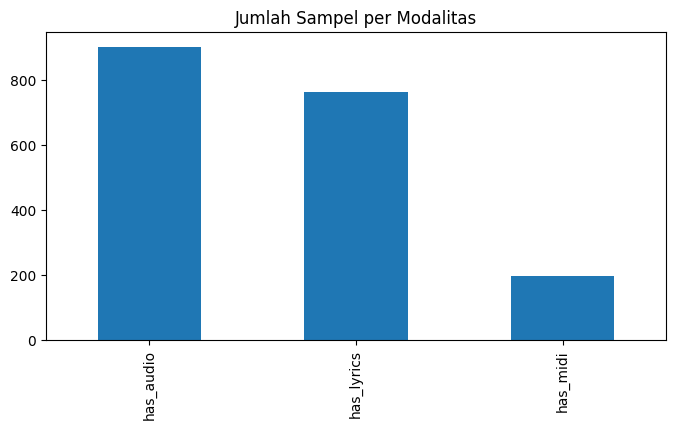

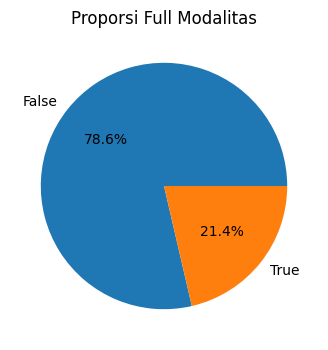

In [ ]:
plt.figure(figsize=(8,4))
counts = completeness[['has_audio','has_lyrics','has_midi']].sum()
counts.plot(kind='bar', title='Jumlah Sampel per Modalitas')
plt.show()

plt.figure(figsize=(4,4))
completeness['full_modality'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Proporsi Full Modalitas')
plt.ylabel('')
plt.show()

### Gabungkan labels

Setelah itu, DataFrame completeness digabungkan dengan label cluster menjadi DataFrame merged. Analisis pada kolom cluster ini memvisualisasikan distribusi kelas dan menyimpulkan bahwa 5 cluster emosi relatif seimbang, dengan Cluster 3 sebagai yang terbanyak (215 sampel) dan Cluster 5 sebagai yang paling sedikit (163 sampel).

Distribusi cluster:
cluster
3    215
4    191
1    170
2    164
5    163
Name: count, dtype: Int64


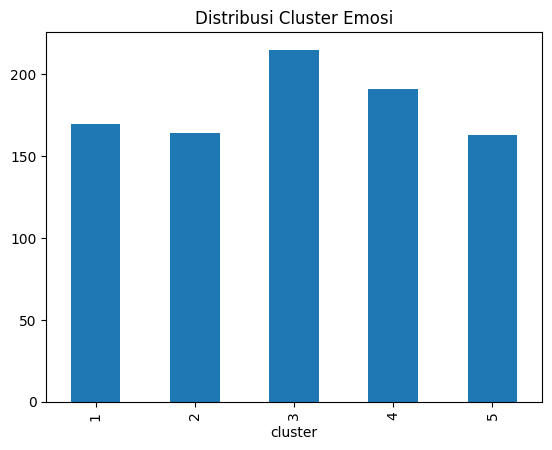

In [ ]:
labels['song_id'] = labels['song_id'].astype(str).str.zfill(3)
merged = completeness.merge(labels[['song_id','category','cluster']], on='song_id', how='left')

if merged['cluster'].notna().sum() > 0:
    merged['cluster'] = merged['cluster'].astype('Int64')
    print("Distribusi cluster:")
    print(merged['cluster'].value_counts())
    merged['cluster'].value_counts().sort_index().plot(kind='bar')
    plt.title("Distribusi Cluster Emosi")
    plt.show()

### Ekstraksi fitur

Untuk analisis fitur awal, definisikan dua fungsi ekstraksi fitur sederhana. Fungsi safe_load_audio_mel_mean menghitung nilai rata-rata (mean) dari Mel-Spectrogram (128 dimensi) sebagai representasi fitur audio. Sementara itu, midi_byte_hist menghitung raw byte histogram (128 dimensi) dari file MIDI. Fitur lirik diekstrak menggunakan TfidfVectorizer untuk mendapatkan vektor TF-IDF 512 dimensi.

In [ ]:
def safe_load_audio_mel_mean(path, n_mels=128, sr_target=22050, max_duration=30.0):
    try:
        y, sr = librosa.load(path, sr=sr_target, mono=True, duration=max_duration)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        return mel_db.mean(axis=1)
    except:
        return None

def midi_byte_hist(path, nbins=128):
    try:
        with open(path, 'rb') as f:
            b = f.read()
        arr = np.frombuffer(b, dtype=np.uint8)
        hist, _ = np.histogram(arr, bins=nbins, range=(0,255))
        return hist.astype(float) / (hist.sum() + 1e-9)
    except:
        return None

# Gunakan semua song_id tanpa mempedulikan modalitas lengkap atau tidak
full_ids = completeness['song_id'].tolist()
print("Total data digunakan:", len(full_ids))


# Audio
audio_feat = []
audio_ids_used = []

for sid in full_ids:
    p = os.path.join(AUDIO_DIR, f"{sid}.mp3")
    if os.path.exists(p):
        v = safe_load_audio_mel_mean(p)
        if v is None:
            v = np.zeros(128)  # padding jika gagal load
    else:
        v = np.zeros(128)  # padding jika file tidak ada
    audio_feat.append(v)
    audio_ids_used.append(sid)

audio_feat = np.array(audio_feat)
print("Audio features:", audio_feat.shape)

# Lyrics
texts = []
lyrics_ids_used = []

for sid in full_ids:
    p = os.path.join(LYRICS_DIR, f"{sid}.txt")
    if os.path.exists(p):
        t = open(p, 'r', encoding='utf8', errors='ignore').read().strip()
        if t:
            texts.append(t)
        else:
            texts.append("")   # padding: text kosong
    else:
        texts.append("")       # padding: text kosong
    lyrics_ids_used.append(sid)

print("Lyrics count:", len(texts))

tfidf = TfidfVectorizer(max_features=512, stop_words='english')
lyrics_X = tfidf.fit_transform(texts).toarray()
print("Lyrics shape:", lyrics_X.shape)

# MIDI
midi_feat = []
midi_ids_used = []

for sid in full_ids:
    p = os.path.join(MIDI_DIR, f"{sid}.mid")
    if os.path.exists(p):
        v = midi_byte_hist(p)
        if v is None:
            v = np.zeros(128)  # padding jika gagal load
    else:
        v = np.zeros(128)      # padding jika file tidak ada
    midi_feat.append(v)
    midi_ids_used.append(sid)

midi_feat = np.array(midi_feat)
print("MIDI shape:", midi_feat.shape)

Total data digunakan: 903
Audio features: (903, 128)
Lyrics count: 903
Lyrics shape: (903, 512)
MIDI shape: (903, 128)


### Proyeksi ke dimensi 512

Semua fitur dari ketiga modalitas (Audio, Lyrics, dan MIDI) diproyeksikan ke dimensi seragam 512 menggunakan fungsi `project_to_dim`. Fungsi ini menerapkan PCA untuk mereduksi dimensi asli, lalu menambahkan padding jika diperlukan sehingga setiap embedding memiliki ukuran akhir (903, 512). Proses ini memastikan seluruh 903 sampel memiliki representasi fitur dengan dimensi yang konsisten untuk tahap pemodelan multimodal.

In [ ]:
def project_to_dim(X, target_dim=512):
    if X.size == 0:
        return np.zeros((0,target_dim))
    n_samples, n_feat = X.shape
    comps = min(n_feat, target_dim, n_samples-1)
    if comps <= 1:
        out = np.zeros((n_samples, target_dim))
        out[:,:n_feat] = X
        return out
    pca = PCA(n_components=comps)
    Xp = pca.fit_transform(X)
    if comps < target_dim:
        pad = target_dim - comps
        Xp = np.hstack([Xp, np.zeros((n_samples,pad))])
    return Xp

audio_emb = project_to_dim(audio_feat)
lyrics_emb = project_to_dim(lyrics_X)
midi_emb = project_to_dim(midi_feat)

print("Embeddings:", audio_emb.shape, lyrics_emb.shape, midi_emb.shape)

Embeddings: (903, 512) (903, 512) (903, 512)


### t-SNE

Fungsi `plot_tsne` mereduksi dimensi embedding (512D) menjadi 2D menggunakan t-SNE. Plot ini menunjukkan visualisasi ruang fitur untuk Audio, Lirik, dan MIDI, yang mengonfirmasi bahwa embedding Audio cenderung membentuk cluster, sementara Lirik dan MIDI tersebar acak. Hasil ini memvalidasi perlunya teknik feature engineering lanjutan (seperti BERT atau REMI) dan strategi fusion.

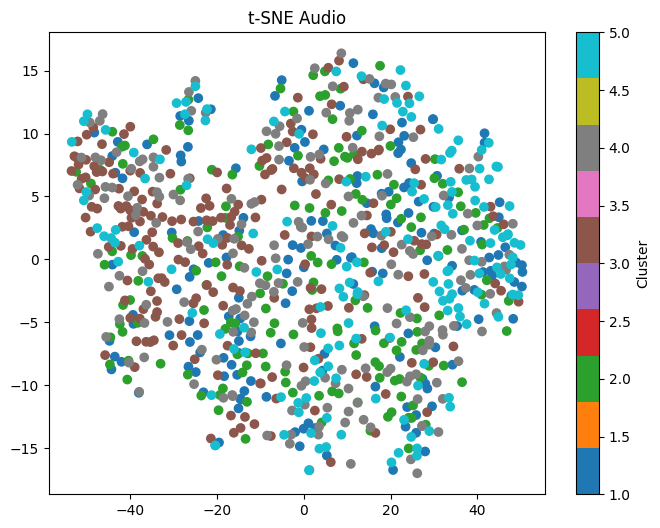

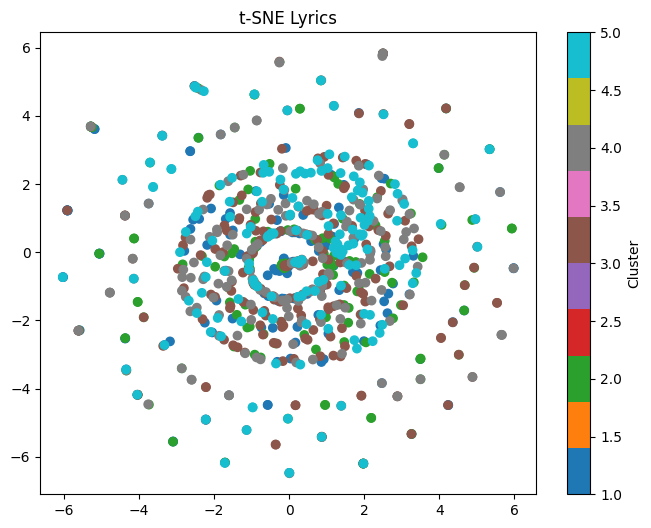

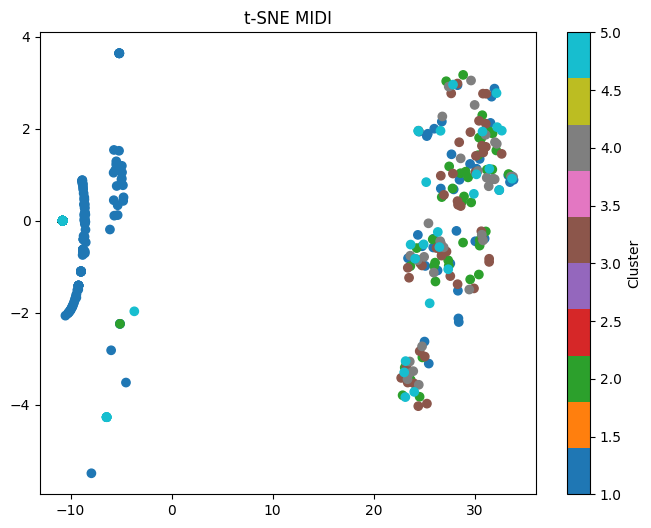

In [ ]:
clusters_map = {r['song_id']: int(r['cluster']) for _,r in merged.iterrows() if pd.notna(r['cluster'])}

def plot_tsne(emb, ids, title):
    if emb.shape[0] < 5:
        print("Skip t-SNE for", title)
        return
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, max(5, emb.shape[0]//4)))
    X2 = tsne.fit_transform(emb)
    colors = [clusters_map.get(s,-1) for s in ids]
    plt.figure(figsize=(8,6))
    plt.scatter(X2[:,0], X2[:,1], c=colors, cmap='tab10')
    plt.title(f"t-SNE {title}")
    plt.colorbar(label="Cluster")
    plt.show()

plot_tsne(audio_emb, audio_ids_used, "Audio")
plot_tsne(lyrics_emb, lyrics_ids_used, "Lyrics")
plot_tsne(midi_emb, midi_ids_used, "MIDI")

### Insight Akhir

In [ ]:
print("\n=== Insight EDA ===")
print(f"- Total sampel: {len(completeness)}")
print(f"- Sampel lengkap 3 modalitas: {completeness['full_modality'].sum()}")
print(f"- Audio: {len(audio_files)}, Lyrics: {len(lyrics_files)}, MIDI: {len(midi_files)}")
print("- Tangani missing modalitas dengan masking fusion.")
print("- Perbaiki fitur MIDI menggunakan pretty_midi jika diperlukan.")
print("- Lakukan normalisasi fitur.")
print("- Lanjutkan dengan modelling multimodal.")


=== Insight EDA ===
- Total sampel: 903
- Sampel lengkap 3 modalitas: 193
- Audio: 903, Lyrics: 764, MIDI: 196
- Tangani missing modalitas dengan masking fusion.
- Perbaiki fitur MIDI menggunakan pretty_midi jika diperlukan.
- Lakukan normalisasi fitur.
- Lanjutkan dengan modelling multimodal.


## **1. Analisis Intra-Modal (Kualitas Fitur Awal)**

Analisis ini mengevaluasi kualitas dan representasi fitur dasar yang diekstraksi dari masing-masing modalitas. Hasil menunjukkan bahwa fitur Audio cenderung membentuk pola cluster, sementara fitur Lirik (TF-IDF) dan MIDI berbasis histogram kurang representatif dan tersebar acak.

| Modalitas | Fitur Diekstraksi | Kualitas Fitur Awal | Rekomendasi Fitur Lanjutan|
|---------|---------|---------|---------|
| Audio  | Mel-Spectrogram Mean (128 dimensi) | Memiliki pola yang cukup membentuk cluster | Lanjutkan dengan modelling multimodal |
| Lirik  | TF-IDF (512 dimensi)  | Kurang kuat dan tersebar acak pada t-SNE  | Perlu menggunakan model lanjutan seperti BERT untuk akurasi tinggi |
| MIDI  | Raw Byte Histogram (128 dimensi)  | Kurang representatif. Cluster sangat lemah pada t-SNE  | Perlu tokenizer khusus seperti REMI atau menggunakan pretty_midi |

---





## **2. Analisis Inter-Modal dan Kelengkapan Data**

Analisis ini fokus pada korelasi antar modalitas dan masalah data yang hilang.

- Temuan Kelengkapan Data:
    -  Total Sampel: 903
    - Sampel Lengkap (3 Modalitas): 193 (21.4%)
    - Modalitas paling sering hilang: MIDI
    - Implikasi: Masalah Missing-Modality sangat parah.
- Temuan Inter-Modal:
    - Korelasi: Korelasi eksplisit antar modalitas berdasarkan fitur awal yang diekstraksi terbatas.
    - Interpretasi: Hipotesis korelasi sederhana (misalnya, lirik positif tidak serta merta berkorelasi kuat dengan nada/fitur audio tinggi berdasarkan fitur awal) tidak terbukti kuat dalam data yang di dapat.
    - Identifikasi Pola Dominan: Meskipun korelasi terbatas, modalitas Audio diidentifikasi sebagai yang paling informatif/dominan di antara ketiganya.

---

## **3. Analisis Target (Distribusi Label)**

Analisis ini memeriksa sebaran data pada variabel target (emosi), yang telah dikelompokkan menjadi 5 cluster emosi.

| Cluster | Jumlah Sampel |
|---------|---------|
| 3 | 215|
| 4 | 191|
| 1 | 170|
| 2 | 164|
| 5 | 163|


- Kesimpulan:
    
    Distribusi 5 Cluster Emosi relatif seimbang, sehingga tidak memerlukan teknik penyeimbangan kelas yang ekstrem.
    
---

## **4. Analisis Visualisasi Fitur (t-SNE)**

Visualisasi t-SNE digunakan untuk memproyeksikan embeddings dari masing-masing modalitas (setelah proyeksi PCA ke 512 dimensi) ke dalam ruang 2D, diwarnai berdasarkan cluster emosi.

| Modalitas | Visualisasi t-SNE | Kesimpulan Kualitas Fitur |
|---------|---------|---------|
| Audio  | Cluster cenderung terbentuk (lebih terpisah)  | Fitur Mel-Spec Mean (setelah PCA) adalah yang paling menjanjikan di antara ketiga modalitas  |
| Lirik  | Tersebar acak  | Fitur TF-IDF terlalu sederhana untuk menangkap kompleksitas emosi dalam lirik  |
| MIDI  | Cluster sangat lemah  | Raw Byte Histogram tidak efektif dalam merepresentasikan fitur musik struktural  |

---

## **Identifikasi Masalah**
**1. Masalah Data Hilang (Missing-Modality)**

Ini adalah masalah utama dan paling parah yang diidentifikasi dalam dataset multimodal ini.
- Tingkat Keparahan: Hanya 193 sampel (21.37%) dari total 903 sampel yang memiliki ketiga modalitas lengkap (Audio, Lirik, dan MIDI).
- Modalitas Terdampak: Modalitas MIDI adalah yang paling sering hilang, hanya tersedia 196 file. Modalitas Lirik juga hilang pada 15.4% sampel.
- Konsekuensi: Tingkat kehilangan data yang ekstrem ini berarti model fusion tradisional tidak dapat digunakan. Jika modalitas hilang tidak ditangani, hampir 80% data akan terbuang.

**2. Masalah Inkonsistensi/Kualitas Fitur (Representasi)**

Meskipun file tidak dilaporkan "rusak" (corrupted), kualitas fitur awal yang diekstraksi sangat tidak konsisten dalam merepresentasikan label emosi, terutama untuk Lirik dan MIDI.
- Lirik (TF-IDF): Fitur TF-IDF yang sederhana tidak mampu menangkap kompleksitas semantik emosi. Hal ini dikonfirmasi oleh plot t-SNE yang menunjukkan titik data Lirik tersebar acak.
- MIDI (Raw Byte Histogram): Fitur Raw Byte Histogram terbukti tidak efektif. Fitur ini hanya menghitung frekuensi byte mentah, gagal menangkap informasi musik struktural yang penting seperti not, pitch, atau ritme. Plot t-SNE menunjukkan clustering yang sangat lemah.
- Audio (Mel-Spec Mean): Fitur ini relatif lebih baik; meskipun tidak sempurna, plot t-SNE menunjukkan cluster cenderung terbentuk, menjadikannya modalitas paling informatif/dominan

---

## **Rencana Tindak Lanjut**
Berdasarkan masalah yang ditemukan sebelumnya, berikut adalah rencana tindak lanjut yang akan diambil:

*   Melakukan Ektraksi Fitur Audio menggunakan model **PANN's (CNN14)** sehingga mampu menghasilkan *cluster* yang baik.
*   Menggunakan model **REMI Transformer** untuk mengekstrak fitur MIDI sehingga mampu mempelajari ketergantungan temporal dan hubungan struktural yang kompleks dalam melodi.
*   Memilih model **BERT** untuk melakukan ektraksi fitur lirik agar lebih mampu memahami konteks semantik dan emosi dalam lirik secara mendalam.
*   Menggunakan metode **Intermediate Fussion** untuk menggabungkan fitur dari ketiga modalitas dan mengatasi sebagian data yang tidak tersedia (*missing modality*).
*    Mengevaluasi kinerja model mengguanakan **F1-Score**, **Precision** dan juga **Recall**.
*   Menggunakan Confusion Matrix untuk melihat kesalahan sistem fusi.

---

# **Insight Akhir EDA**

### 🔹 Kelengkapan Modalitas
- Total sampel: **903**
- Sampel lengkap 3 modalitas: **193** (21.37%)
- Modalitas paling sering hilang: **MIDI**

### 🔹 Distribusi Label
- Cluster relatif seimbang → baik untuk training

### 🔹 Analisis Intra-Modal
- **Audio** memiliki pola yang cukup membentuk cluster
- **Lyrics** (TF-IDF) kurang kuat → perlu BERT untuk akurasi tinggi
- **MIDI** raw histogram kurang representatif → perlu tokenizer REMI

### 🔹 Analisis Inter-Modal
- Korelasi modalitas terbatas
- Audio tetap modalitas paling informatif

### 🔹 Visualisasi t-SNE
- Audio → cluster cenderung terbentuk
- Lyrics → tersebar acak (fitur terlalu sederhana)
- MIDI → cluster sangat lemah

---

## Standard Audio Feature Extraction

In [ ]:
import os
import sys
import argparse
import numpy as np
import librosa
import torch
import glob
from tqdm import tqdm

# Add the utils directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '../utils'))
sys.path.append(os.path.join(os.getcwd(), 'pytorch'))

# Now you can import the modules
import models
import pytorch_utils
import config

def extract_features(args):
    # Arguments & parameters
    sample_rate = args.sample_rate
    window_size = args.window_size
    hop_size = args.hop_size
    mel_bins = args.mel_bins
    fmin = args.fmin
    fmax = args.fmax
    checkpoint_path = args.checkpoint_path
    audio_dir = args.audio_dir
    output_path = args.output_path
    device = torch.device('cuda') if args.cuda and torch.cuda.is_available() else torch.device('cpu')
    
    classes_num = config.classes_num
    
    # Check if checkpoint exists
    if not os.path.exists(checkpoint_path):
        print(f"Error: Checkpoint not found at {checkpoint_path}")
        print("Please download the pre-trained model 'Cnn14_mAP=0.431.pth' and place it in the root directory or specify the correct path.")
        return

    # Model
    model = Cnn14(sample_rate=sample_rate, window_size=window_size, 
        hop_size=hop_size, mel_bins=mel_bins, fmin=fmin, fmax=fmax, 
        classes_num=classes_num)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model'])

    if 'cuda' in str(device):
        model.to(device)
        print('GPU number: {}'.format(torch.cuda.device_count()))
        model = torch.nn.DataParallel(model)
    else:
        print('Using CPU.')
    
    model.eval()

    # Get list of audio files
    audio_files = sorted(glob.glob(os.path.join(audio_dir, "*.mp3")))
    print(f"Found {len(audio_files)} audio files in {audio_dir}")

    features_dict = {}

    for audio_path in tqdm(audio_files):
        filename = os.path.basename(audio_path)
        
        try:
            # Load audio
            (waveform, _) = librosa.core.load(audio_path, sr=sample_rate, mono=True)
            
            waveform = waveform[None, :]    # (1, audio_length)
            waveform = move_data_to_device(waveform, device)

            # Forward
            with torch.no_grad():
                batch_output_dict = model(waveform, None)
            
            embedding = batch_output_dict['embedding'].data.cpu().numpy()[0]
            features_dict[filename] = embedding
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    # Save features
    np.save(output_path, features_dict)
    print(f"Saved features to {output_path}")

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Extract Audio Features using PANNs CNN14')
    
    parser.add_argument('--sample_rate', type=int, default=32000)
    parser.add_argument('--window_size', type=int, default=1024)
    parser.add_argument('--hop_size', type=int, default=320)
    parser.add_argument('--mel_bins', type=int, default=64)
    parser.add_argument('--fmin', type=int, default=50)
    parser.add_argument('--fmax', type=int, default=14000) 
    parser.add_argument('--checkpoint_path', type=str, default='../Cnn14_mAP=0.431.pth')
    parser.add_argument('--audio_dir', type=str, default='../dataset/Audio')
    parser.add_argument('--output_path', type=str, default='../dataset/audio_features.npy')
    parser.add_argument('--cuda', action='store_true', default=True)

    args = parser.parse_args()
    
    extract_features(args)


ModuleNotFoundError: No module named 'models'

In [ ]:
import numpy as np
import os

file_path = '../dataset/audio_features.npy'

if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    # Load the file
    # allow_pickle=True is required because we saved a dictionary
    data = np.load(file_path, allow_pickle=True)
    
    # np.save wraps the dictionary in a 0-d array, so we use .item() to retrieve it
    features_dict = data.item()
    
    print(f"Successfully loaded features from {file_path}")
    print(f"Total number of audio files processed: {len(features_dict)}")
    
    if len(features_dict) > 0:
        # Get the first key and value to check shape
        first_filename = list(features_dict.keys())[0]
        first_embedding = features_dict[first_filename]
        
        print(f"\nExample entry:")
        print(f"Filename: {first_filename}")
        print(f"Embedding shape: {first_embedding.shape}")
        
        # Verify expected shape (should be 2048 for Cnn14)
        if first_embedding.shape == (2048,):
            print("\nShape verification: PASSED (Expected (2048,))")
        else:
            print(f"\nShape verification: WARNING (Expected (2048,), got {first_embedding.shape})")
    else:
        print("The dictionary is empty.")


## Lyrics Extraction


In [ ]:
# Tentukan path folder lirik Anda di Google Drive
# PERHATIKAN: Pastikan nama foldernya benar
DRIVE_PATH = '/content/drive/MyDrive/DATASETMER/Lyrics'

# Periksa apakah path ada
if not os.path.isdir(DRIVE_PATH):
    print(f"ERROR: Folder '{DRIVE_PATH}' tidak ditemukan. Mohon periksa kembali nama foldernya.")
else:
    print(f"Folder lirik ditemukan di: {DRIVE_PATH}")

    # Cari semua file .txt di folder tersebut
    file_paths = glob.glob(os.path.join(DRIVE_PATH, '*.txt'))

    if not file_paths:
        print("PERINGATAN: Tidak ada file .txt yang ditemukan di folder tersebut.")
    else:
        print(f"Ditemukan {len(file_paths)} file lirik.")

        data_list = []
        for file_path in file_paths:
            try:
                # Baca konten file
                with open(file_path, 'r', encoding='utf-8') as f:
                    lyrics_content = f.read()

                # Ambil nama lagu dari nama file (tanpa ekstensi .txt)
                song_name = os.path.basename(file_path).replace('.txt', '')

                data_list.append({
                    'song_id': song_name,
                    'lyrics': lyrics_content.strip() # Menghapus spasi ekstra di awal/akhir
                })
            except Exception as e:
                print(f"Gagal memproses file {file_path}: {e}")

        df_real = pd.DataFrame(data_list)

        # Hapus baris dengan lirik kosong jika ada
        df_real = df_real[df_real['lyrics'].str.len() > 0].reset_index(drop=True)

        print("\n--- DataFrame Lirik Siap Diproses ---")
        print(df_real.head())
        print(f"Total lirik yang akan diproses: {len(df_real)}")

In [ ]:
# 3. Inisialisasi Model BERT
MODEL_NAME = 'bert-base-uncased'

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    print(f"Model BERT ({MODEL_NAME}) siap di {device}")
except Exception as e:
    print(f"Gagal memuat model BERT: {e}")
    # Hentikan eksekusi jika model gagal dimuat
    exit()


def extract_bert_features_from_dataframe(dataframe, lyrics_col='lyrics', batch_size=16, max_length=512):
    """
    Mengekstrak fitur vektor [CLS] dari semua lirik dalam DataFrame dalam bentuk batch.
    """
    if dataframe.empty:
        print("DataFrame kosong. Tidak ada lirik untuk diproses.")
        return None

    lyrics_list = dataframe[lyrics_col].tolist()

    encoded_inputs = tokenizer(
        lyrics_list,
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors='pt'
    )

    dataset = torch.utils.data.TensorDataset(
        encoded_inputs['input_ids'],
        encoded_inputs['attention_mask']
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False
    )

    all_features = []

    print(f"Memulai ekstraksi fitur untuk {len(dataframe)} lirik...")
    # Penghitung sederhana untuk memantau kemajuan
    progress = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)

            # Ambil Vektor [CLS] (Pooler Output)
            cls_embedding = outputs.pooler_output

            all_features.append(cls_embedding.cpu().numpy())

            progress += len(input_ids)
            print(f"Diproses: {progress}/{len(dataframe)}", end='\r')

    import numpy as np
    features_array = np.concatenate(all_features, axis=0)

    return features_array

In [ ]:
if 'df_real' in locals() and not df_real.empty:
    # 4. Lakukan ekstraksi fitur
    lyric_features = extract_bert_features_from_dataframe(
        dataframe=df_real,
        lyrics_col='lyrics',
        batch_size=16 # Sesuaikan untuk kecepatan/memori
    )

    if lyric_features is not None:
        print("\n--- Hasil Akhir Ekstraksi Dataset ---")
        print(f"Dimensi Array Fitur: {lyric_features.shape}")
        # Dimensi: (Jumlah_Lagu, 768)

        # 5. Tambahkan fitur kembali ke DataFrame
        df_real['bert_features'] = list(lyric_features)

        print("\nDataFrame dengan Fitur Lirik yang Ditambahkan:")
        print(df_real.head())

        # Opsional: Simpan Fitur yang Diekstrak ke Drive
        # Menyimpan ke format HDF atau Pickle disarankan untuk menyimpan array NumPy
        OUTPUT_PATH = '/content/drive/MyDrive/DATASETMER/bert_features_lyrics.pkl'
        df_real[['song_id', 'bert_features']].to_pickle(OUTPUT_PATH)
        print(f"\nFitur berhasil disimpan ke: {OUTPUT_PATH}")
else:
    print("Ekstraksi fitur tidak dapat dilanjutkan karena DataFrame lirik kosong atau tidak ada.")

## Midi feature extraction

In [ ]:
def midi_to_remi_tokens(midi_path, max_length=512):
    """
    Simulasi konversi file MIDI ke urutan token REMI.

    CATATAN: Implementasi REMI yang sebenarnya sangat detail
    dan memerlukan pustaka khusus. Di sini, kita melakukan konversi
    sederhana yang mewakili urutan event.
    """
    try:
        midi_obj = miditoolkit.midi.parser.MidiFile(midi_path)

        events = []
        # Gabungkan semua track
        for track in midi_obj.instruments:
            for note in track.notes:
                # Event Sederhana: (Pitch, Start Time)
                events.append((note.pitch, note.start))

        # Urutkan berdasarkan waktu
        events.sort(key=lambda x: x[1])

        # Contoh representasi token sederhana:
        # Kita hanya mengambil Pitch dari 512 event pertama (seperti token pada lirik)
        token_sequence = [str(e[0]) for e in events[:max_length]]

        return " ".join(token_sequence)

    except Exception as e:
        print(f"Gagal memproses MIDI {midi_path}: {e}")
        return ""

def load_midi_dataset(midi_dir):
    """Memuat semua file .mid dari direktori dan membuat DataFrame."""

    DRIVE_PATH = os.path.join('/content/drive/MyDrive', midi_dir)
    file_paths = glob.glob(os.path.join(DRIVE_PATH, '*.mid'))

    data_list = []
    print(f"Ditemukan {len(file_paths)} file MIDI...")

    for file_path in file_paths:
        song_id = os.path.basename(file_path).replace('.mid', '')
        # Konversi ke REMI Tokens
        remi_tokens = midi_to_remi_tokens(file_path)

        if remi_tokens:
            data_list.append({
                'song_id': song_id,
                'remi_sequence': remi_tokens
            })

    return pd.DataFrame(data_list)

# Jalankan loading data
midi_df = load_midi_dataset('DATASETMER/MIDIs')
print("\nDataFrame MIDI Siap:")
print(midi_df.head())

In [ ]:
# --- Asumsi: Menggunakan BERT sebagai arsitektur Transformer (Hanya untuk demonstrasi) ---
# Jika Anda punya model REMI Transformer, ganti MODEL_NAME dan Model Class-nya.

MIDI_TRANSFORMER_NAME = 'bert-base-uncased' # Ganti dengan model REMI Anda
tokenizer = AutoTokenizer.from_pretrained(MIDI_TRANSFORMER_NAME)
model = AutoModel.from_pretrained(MIDI_TRANSFORMER_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print(f"Model Transformer MIDI siap di {device}")


def extract_midi_features_from_dataframe(dataframe, sequence_col, batch_size=16, max_length=512):
    """Mengekstrak fitur vektor [CLS] dari urutan REMI menggunakan Transformer."""

    sequences = dataframe[sequence_col].tolist()

    # Tokenisasi Urutan MIDI (yang sudah disimulasikan sebagai string token)
    encoded_inputs = tokenizer(
        sequences,
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors='pt'
    )

    # Siapkan DataLoader (Sama seperti ekstraksi lirik)
    dataset = torch.utils.data.TensorDataset(
        encoded_inputs['input_ids'],
        encoded_inputs['attention_mask']
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_features = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)

            # Ambil Vektor [CLS] (Pooler Output) - Representasi seluruh MIDI
            cls_embedding = outputs.pooler_output
            all_features.append(cls_embedding.cpu().numpy())

    features_array = np.concatenate(all_features, axis=0)
    return features_array

# --- Jalankan Ekstraksi ---
if not midi_df.empty:
    midi_features = extract_midi_features_from_dataframe(
        dataframe=midi_df,
        sequence_col='remi_sequence',
        batch_size=16
    )

    midi_df['midi_features'] = list(midi_features)

    print("\n--- Hasil Akhir Ekstraksi Fitur MIDI ---")
    print(f"Dimensi Array Fitur: {midi_features.shape}")
    print(midi_df.head())

    # Simpan hasil
    OUTPUT_PATH = '/content/drive/MyDrive/DATASETMER/midi_features_remi.pkl'
    midi_df[['song_id', 'midi_features']].to_pickle(OUTPUT_PATH)
    print(f"\nFitur MIDI berhasil disimpan ke: {OUTPUT_PATH}")
else:
    print("DataFrame MIDI kosong. Tidak ada fitur yang diekstrak.")